In [1]:
from scipy.integrate import solve_ivp

A collection of useful functions for numerical simulations and plotting

Variables: 
- `colors` (red, orange, magenta, purple, cornflowerblue, turquoise)
- `Plab`
- `Pscaledlab`
- `N1lab`
- `N2lab`
- `Tlab`
- `mean_x_lab`
- `freq_x_lab`
- `β1lab`
- `gxlab`
- `figure_ops` (settings for saving figures)

Functions:
- `get_initial_points`
- `update_params`
- `format_ax`
- `get_traj_plot_input`
- `get_results`
- `add_arrow`
- `plot_all`
- `plot_x_vs_y`
- `plot_portion_x`
- `print_param_caption`
- `plot_F_equilibrium`
- `plot_freq_x_eq`
- `plot_W_mode_comparison`
- `get_traj_plot_input`
- `make_traj_plots`

In [1]:
%%writefile sim_graph_funs.py
import numpy as np
import matplotlib.pyplot as plt
from fitness_funs_non_dim import *
from group_w_pop_funs import *
from scipy.integrate import solve_ivp
from scipy.optimize import root
from local_stability_funs import *
#from equilibria_funs import *


#colors = ['k','r','b','cyan', 'magenta','orange',
#         'gray', 'green']
colors = ['r', 'orange', 'magenta', 'purple', 'blue', 
          'cornflowerblue', 'turquoise','k', 'gray']
colors_x = ['k', 'b', 'r', 'm']
#markers = ["o","","v", ""]
Plab = r'$p$,  Pred. Pop Density'
Pscaledlab = r'$P$,  Pred. Scaled Density'
N1lab = r'$N_1$, Scaled Big Prey'+ '\nDensity'
N2lab = r'$N_2$, Scaled Small Prey' + '\nDensity'
Tlab = r'$T$, Scaled time'
mean_x_lab = "Mean Experienced\nGroup Size"
freq_x_lab = r'Freq$(x)$'
β1lab = r'$\beta_1$'
gxlab = r'g$(x)$'
def gxlabel(i):
    first_three = ["Density of singletons,\n" + r'$g(1)$', 
                   "Density of pairs,\n" + r'$g(2)$', 
                   "Density of trios,\n" + r'$g(3)$'] 
    if i <4:
        return first_three[i-1]
    else:
        return "Density of groups\n of size %d, "%i + r'$g($' + str(i) + r'$)'
standard_labs = dict(
    p = r'$p$,  Pred. Density', N1 = r'$N_1$, Scaled Big Prey'+ '\nDensity', 
    N2 = r'$N_2$, Scaled Small Prey' + '\nDensity', T = r'$T$, Scaled time',
    mean_x = "Mean Experienced\nGroup Size",
    freq_x = r'Freq$(x)$', β1 = r'$\beta_1$', gx = r'g$(x)$', 
    var = "Variance of\nExperienced Group Size"
)

figure_ops = dict(bbox_inches = 'tight', 
                  format = 'eps', dpi=300, transparent=False,
                 pad_inches=0)

param_lab_dic = dict(η1 = "Growth of big prey, " + r'$\eta_1$', 
            η2 = "Growth of small prey, " + r'$\eta_2$', 
            A = "Relative Attack Rate of Both prey," + r'$A_1=A_2=A$',
            A1 = "Relative Attack rate of Big Prey, " + r'$A_1$', 
            A2 = "Relative Attack rate of Small Prey, " + r'$A_2$', 
            β1 = "Benefit of big prey, " + r'$\beta_1$',
            β2 = "Benefit of small prey, " + r'$\beta_1$', 
            H1a= "Group-independent Handling\ntime of big prey, " + r'$H_{1a}$', 
            H2a= "Group-independent Handling\ntime of small prey," + r'$H_{2a}$', 
            H1b= "Group-dependent Handling\ntime of big prey, " + r'$H_{1b}$', 
            H2b= "Group-dependent Handling\ntime of small prey," + r'$H_{2b}$', 
            α1_of_1= "Capture probability of big prey\nby solitary predator, " + r'$\alpha_1(1)$',
            α2_of_1="Capture probability of small prey\nby solitary predator, " + r'$\alpha_2(1)$', 
            s1="Critical group size for big prey, " + r'$s_1$', 
            s2="Critical group size for small prey, " + r'$s_2$', 
            α2_fun_type = 'Shape of capture probability for small prey',
            x_max = 'Max group size, ' + r'$x_{max}$',
            d = "Decision accuracy, " + r'$d$',
            Tx = "Timescale of group dynamics, " + r'$T_x$',
            scale = "Prey size ratio, " + r'$\beta_1/\beta_2$')




def format_ax(ax,xlab,ylab, xlim = None, ylim=None,
              fs_labs = 20, fs_legend = 16, if_legend = False,
             ncol_legend = 1):
    '''
    applies my formatting to provided ax:
    sets xlim, ylim, and fontsizes. gets rid of right and top borders, 
    adds legend
    @ no return
    '''
    ax.set_xlabel(xlab, fontsize = fs_labs)
    ax.set_ylabel(ylab, fontsize = fs_labs)
    if xlim != None:
        ax.set_xlim(xlim)
    if ylim != None:
        ax.set_ylim(ylim)
    for s in ['top', 'right']:
        ax.spines[s].set_visible(False)
    if if_legend:
        ax.legend(fontsize = fs_legend, ncol = ncol_legend)
        
def get_results(out2,x_max):
    '''
    gets results from output of simulation
    out: dictionary that's output of solve_ivp
    x_max: max group size

    @returns:
    T, N1, N2, P, g_of_x_vec, mean_x
    '''
    N1, N2 = out2.y[0:2]
    g_of_x_vec = out2.y[2:]
    xvec = np.arange(1,x_max+1,1)
    p = np.sum(xvec*g_of_x_vec.T,1)
    mean_x = mean_group_size_membership(g_of_x_vec.T, x_max, p)
    T = out2.t
    return T, N1, N2, p, g_of_x_vec, mean_x
def add_arrow(line, start_ind = None,  direction='right', size=15, color=None):
    """
    add an arrow to a line.
    Edited from https://stackoverflow.com/questions/34017866/arrow-on-a-line-plot

    line:       Line2D object
    start_ind:   index of start of the arrow
    direction:  'left' or 'right'
    size:       size of the arrow in fontsize points
    color:      if None, line color is taken.
    """
    #position=None,
    
    if color is None:
        color = line.get_color()

    xdata = line.get_xdata()
    ydata = line.get_ydata()

    #if position is None:
    #    position = xdata.mean()
    # find closest index
    if start_ind == None:
        position = xdata.mean()
        start_ind = np.argmin(np.absolute(xdata - position))
    if direction == 'right':
        end_ind = start_ind + 1
    else:
        end_ind = start_ind - 1
    line.axes.annotate('',
        xytext=(xdata[start_ind], ydata[start_ind]),
        xy=(xdata[end_ind], ydata[end_ind]),
        arrowprops=dict(arrowstyle="->", color=color, 
                        mutation_scale=15)
    )
    


def plot_all(T,N1,N2,p,mean_x, xlim = [-10, 600]):
    '''
    plots N1, N2, p, and mean experienced group size
    versus scaled time

    @return: fig, ax
    '''
    fig, ax = plt.subplots(1,1)
    ax.plot(T,N2,'k', label = r'$N_2$')
    ax.plot(T,N1,'r', label = r'$N_1$')
    ax.plot(T,p,'b', label = r'$p$')
    if isinstance(mean_x, np.ndarray):
        ax.plot(T, mean_x, 'magenta', label = r'$\bar{x}$')
    format_ax(ax, xlab = Tlab,ylab = '',if_legend = True,
         xlim = xlim,fs_labs = 18)
    return fig, ax
def plot_x_vs_y(x,y,xlab,ylab,arrow_inds):
    '''
    plots x on horizontal axis, y on vertical axis
    adds arrows at x[arrow_inds]

    @returns: fig, ax
    '''
    fig, ax = plt.subplots(1,1)
    l = ax.plot(x,y,'k')
    for ind in arrow_inds:
        add_arrow(l[0], start_ind = ind)
        format_ax(ax, xlab = xlab, ylab = ylab, fs_labs = 18)
    return fig, ax
    
def plot_portion_x(fig, ax, out, x_max, xlim = [-1,500], ncol_legend = 1):
    '''
    plots time vs x*f(x)
    out is output from solve_ivp
    @inputs
    ax is the axis that is already made
    out is the output of solve_ivp

    @ returns: fig, ax
    '''
    T = out.t
    print(T[-1])
    g_of_x_vec = out.y[2:]

    xvec = np.arange(1,x_max+1,1)
    xg = xvec*g_of_x_vec.T

    p = np.sum(xg,1)
    
    # find F_of_x that are big enough
    portion_x = (xg.T/p).T

    portion_x[p<1e-10] = np.nan
    
    xlist = []
    xglist = []
    for x in range(1,x_max+1):
        portion_x_curr = portion_x[:,x-1]
        if max(portion_x_curr)>.1:
            xlist.append(x)
            xglist.append(portion_x_curr)
            
    labels = [f'x={x}' for x in xlist]
    for i, portion_x_curr in enumerate(xglist):
        ax.plot(T, portion_x_curr, label = labels[i], c = colors[i])
        
    format_ax(ax,Tlab,r'$xg(x)/p$', xlim = xlim, ylim=None,
              fs_labs = 20, fs_legend = 16, if_legend = True, ncol_legend = ncol_legend)
    return fig, ax

def print_param_caption(Tx, η1, η2, A1, A2, β1, β2, H1a, H1b, H2a, H2b,
                        α1_of_1, α2_of_1, 
                        s1, s2, α2_fun_type,**params):
    '''
    Prints parameter caption in latex format
    no return
    '''
    caption = 'The parameters are '
    caption += f'$\\eta_1 = {η1}, \\eta_2 = {η2}, '
    caption += f'A_ 1= {A1}, A_2= {A2}, \\beta_1 = {β1}, \\beta_2 = {β2}, '
    caption += 'H_{1a} =' +f'{H1a}, ' 'H_{1b} =' + f'{H1b}, '
    caption += 'H_{2a}' +f' = {H2a}, ' + 'H_{2b}' + f'{H2b}, T_x = {Tx}, ' 
    if α2_fun_type == 'constant':
        caption += f'\\alpha_1(1) = {α1_of_1}, s_1 ={s1}$, '
        caption += f'and $\\alpha_2(x) = {α2_of_1}$ is constant.'
    else:
        caption += f'\\alpha_1(1) = {α1_of_1}, \\alpha_2(1) = {α2_of_1}, '
        caption += f's_1 = {s1}$, and $s_2 = {s2}$' 
    
    print(caption)





def get_traj_plot_input(params, t_f = 1000, initial_points = None, 
                        num_init=4):
    '''
    initial_points is either none (so generates initial points) 
    or a list of up to 4 points, each of form [N1,N2, g(1), g(2), ..., g(xm)]
    '''
    if type(initial_points) != np.ndarray: # so it's None or some invalid entry
        print("generating initial points")
        initial_points = get_initial_points(num_init,**params)
    trajectories = []
    for i, init_state in enumerate(initial_points):
        #out2 = solve_ivp(grp.full_model, [0, t_f], init_state, 
        #                 method = "LSODA", args = (True, params))
        # results  = get_results(out2, x_max) # T, N1, N2, P, g_of_x_vec, mean_x
        results = bounded_ivp(init_state, params, t_f = t_f, if_dict=True)
        trajectories.append(results)
    return trajectories # each is a dictionary
def plot_with_arrow(ax, x,y,i, label, start_ind):
    """
    Plots a line on the given axis with optional arrows and a marker for the endpoint.

    Parameters:
    -----------
    ax : matplotlib.axes.Axes
        The axis on which to plot the line.
    x : array-like
        X-coordinates of the data points.
    y : array-like
        Y-coordinates of the data points.
    i : int
        Index for selecting the color from `colors_x`.
    label : str
        Label for the plotted line.
    start_ind : int or list of int
        Index (or indices) indicating where to place arrows along the line.

    Behavior:
    ---------
    - Plots the line with the specified color and label.
    - If the last two points are very close (within 1e-6 tolerance), marks the endpoint with an orange star.
    - Adds arrows at the specified indices to indicate directionality.

    Notes:
    ------
    - The function assumes `colors_x` is a predefined list of colors.
    - Calls `add_arrow()` to add arrows to the plot.

    """
    l = ax.plot(x,y,colors_x[i], label = label)
    line_zorder = l[0].get_zorder()
    if np.all(np.abs([x[-1] - x[-2], y[-1]-y[-2]])<1e-6):
        ax.scatter(x[-1],y[-1],c='orange', edgecolors = 'k',linewidths=.4,
                   marker = "*", s = 100, zorder=line_zorder+1)

    #plot arrows
    if type(start_ind) == int:
        start_ind = [start_ind]
    for elt in start_ind:
        add_arrow(l[0], start_ind = elt)   
        

def plot_trajectory(key_x, key_y, trajectories, xlab=None,
                    ylab=None, start_inds=[50, 50, 50, 50],
                    if_legend=False, g_x = None, g_y = None):
    '''
    Plots two state variables from a set of trajectories.

    Args:
        key_x (str): The key corresponding to the state variable to plot on the x-axis.
        key_y (str): The key corresponding to the state variable to plot on the y-axis.
        trajectories (list of dict): A list of dictionaries, where each dictionary represents a trajectory.
            Each dictionary should have the state variables as keys, and their values as lists or arrays.
        xlab (str, optional): Label for the x-axis. If not provided, uses `standard_labs[key_x]`.
        ylab (str, optional): Label for the y-axis. If not provided, uses `standard_labs[key_y]`.
        start_inds (list of int, optional): Indices indicating where to start plotting arrows for each trajectory.
            Default is [50, 50, 50, 50].
        if_legend (bool, optional): Whether to include a legend on the plot. Default is False.
        g_x (integer, optional): The group size density to plot on the x axis
        g_y (integer, optional): the group size density to plot on the y axis

    Returns:
        fig (matplotlib.figure.Figure): The figure object containing the plot.
        ax (matplotlib.axes.Axes): The axes object for the plot.

    Behavior:
        - Iterates through the list of trajectories and plots the selected state variables.
        - Labels the axes using either the provided `xlab` and `ylab` or default labels from `standard_labs`.
        - Formats the axis using the `format_ax` function.
        - Optionally includes a legend if `if_legend` is set to True.

    Dependencies:
        - `standard_labs`: A dictionary mapping state variable keys to their corresponding axis labels.
        - `format_ax`: A custom function to format the axis.
        - `plot_with_arrow`: A custom function to plot trajectories with arrows starting at specified indices.
    '''
    fig, ax = plt.subplots(1,1)

    # set the label for the horizontal axis
    if key_x == 'g':
        if g_x == None:
            print('Need a group size for horizontal axis')
        xlab = gxlabel(g_x)
    else:
        xlab = standard_labs[key_x] if xlab == None else xlab
        print(xlab)
    
    # set the label for the vertical axis
    if key_y == 'g':
        if g_y == None:
            print('Need a group size for vertical axis')
        ylab = gxlabel(g_y)
    else:
        ylab = standard_labs[key_y] if ylab == None else ylab

            
    for i, traj in enumerate(trajectories):
        label = "Initial State %d"%i
        # set the variables for the horizontal (x_var) and vertical axis (y_var)
        x_var = traj['g'][g_x-1] if key_x == 'g' else traj[key_x]
        y_var = traj['g'][g_y-1] if key_y == 'g' else traj[key_y]
        # plot with arrows starting at start_inds
        plot_with_arrow(
            ax, x_var, y_var, i,
                            label, start_inds[i])
    format_ax(ax, xlab, ylab, if_legend = if_legend)
    return fig, ax
    
def plot_trajectory_vs_T(key_y, trajectories, 
                     ylab = None, if_legend = False, g_y = None):
    '''
    Plots a state variable versus scaled time from a set of trajectories.

    Args:
        key_y (str): The key corresponding to the state variable to plot on the y-axis. 
                    If a group density, uses g_y to determine which one
        trajectories (list of dict): A list of dictionaries, where each dictionary represents a trajectory.
            Each dictionary should have the state variables as keys, and their values as lists or arrays.
        ylab (str, optional): Label for the y-axis. If not provided, uses `standard_labs[key_y]`.
        start_inds (list of int, optional): Indices indicating where to start arrows for each trajectory.
            Default is [50, 50, 50, 50].
        if_legend (bool, optional): Whether to include a legend on the plot. Default is False.
        g_y (int, optional): group size of group density to plot
    Returns:
        fig (matplotlib.figure.Figure): The figure object containing the plot.
        ax (matplotlib.axes.Axes): The axes object for the plot.

    Behavior:
        - Iterates through the list of trajectories and plots the selected state variable versus T.
        - Labels the axes using either the provided ``ylab` or default labels from `standard_labs`.
        - Formats the axis using the `format_ax` function.
        - Optionally includes a legend if `if_legend` is set to True.

    Dependencies:
        - 'colors_x': a list of colors ['k', 'b', 'r', 'm']
        - `standard_labs`: A dictionary mapping state variable keys to their corresponding axis labels.
        - `format_ax`: A custom function to format the axis.
    '''
    fig, ax = plt.subplots(1,1)
    # set the label for the vertical axis
    if key_y == 'g':
        if g_y == None:
            print('Need a group size for vertical axis')
        ylab = gxlabel(g_y)
    else:
        ylab = standard_labs[key_y] if ylab == None else ylab
        
    for i, traj in enumerate(trajectories):
        y_var = traj['g'][g_y-1] if key_y == 'g' else traj[key_y]
        label = "Initial State %d"%i
        plt.plot(
            traj['T'], y_var, colors_x[i], label = label
        )
    format_ax(ax, standard_labs['T'], ylab, if_legend = if_legend)
    return fig, ax

def make_traj_plots(params, t_f =1000, 
               grp_size1 = 2, grp_size2 = 3, start_inds = None,
              initial_points = None, num_init = 4,
                   if_legend = False):
    '''
    Plots trajectories from four initial plots, and plots on the trajectories four different projections: 
        1. N1 vs mean experienced group size
        2. N1 vs N2
        3. g(1) vs g(grp_size1)
        4. g(1) vs g(grp_size2)
        5. variance vs time
    initial points: list of initial points of form [N1, N2, g(1), g(2), ..., g(x_max)]
    Arguments
    - params: params dictionary
    - t_f: final time point for solve_ivp simulation
    - grp_size1: group size on y axis of ax_g2
    - grp_size2: group size for y axis of ax_g3
    - start_inds: start index for arrow on plots in ax1, axN, ax_g2, ax_g3

    Returns
    (tuple) fig1, figN, fig_g2, fig_g3, fig_var
    '''

    if start_inds == None:
        print('No start indices for arrows. Using 50.')
        row = [50,50,50,50]
        start_inds = [row,row,row,row]
    fig1, ax1 = plt.subplots(1,1) # N1 vs mean_x
    figN, axN = plt.subplots(1,1) # N1 vs N2
    fig_g2, ax_g2 = plt.subplots(1,1) #g(1) vs g(2)
    fig_g3, ax_g3 = plt.subplots(1,1) #g(1) vs g(3)
    fig_var, ax_var = plt.subplots(1,1) #variance vs T
    
    trajectories = get_traj_plot_input(params, t_f = t_f, 
                                       initial_points = initial_points,
                                       num_init = num_init)
    
    for i, traj in enumerate(trajectories):
        #T, N1, N2, P, g_of_x_vec, mean_x = traj
        if np.any(np.isnan(traj['mean_x'])):
            print("oh no! mean x is nan")
        elif  np.any(traj['mean_x']<0):
            print("oh no! mean x is negative")
            print("i=%d"%i)
        # check 
        label = "Initial State %d"%i
        plot_with_arrow(ax1, traj['N1'], traj['mean_x'],i,
                        label, start_inds[0][i])
        plot_with_arrow(axN, traj['N1'], traj['N2'], i, 
                        label, start_inds[1][i])
        #g(1) vs g(grp_size1)
        plot_with_arrow(ax_g2, traj['g'][0], traj['g'][grp_size1-1], i, 
                        label, start_inds[2][i])
        #g(1) vs g(grp_size2)
        plot_with_arrow(ax_g3, traj['g'][0], traj['g'][grp_size2 - 1], i, 
                        label, start_inds[3][i])
        # variance
        ax_var.plot(traj['T'],traj['var'], colors_x[i], label = label)
        #plot_with_arrow(ax_var, traj['T'],traj['var'], i, label

        #axN.plot(N1, N2, colors_x[i], label = label)
        #ax_g2.plot(g_of_x_vec[0], g_of_x_vec[1], colors_x[i], label = label)
        #ax_g3.plot(g_of_x_vec[0], g_of_x_vec[2], colors_x[i], label = label)

    format_ax(ax1, N1lab,mean_x_lab, if_legend = if_legend)
    format_ax(axN, N1lab,N2lab, if_legend = if_legend)
    format_ax(ax_g2, 'g(1)', 'g(%d)'%grp_size1, if_legend = if_legend)
    format_ax(ax_g3, 'g(1)', 'g(%d)'%grp_size2, if_legend = if_legend)

    return fig1, figN, fig_g2, fig_g3, fig_var


Overwriting sim_graph_funs.py


# Check Plotting Trajectories

In [27]:
H = 1
x_max = 5
#A = 0.6
params_base = dict(η1 = 0.1, η2 = 0.6, A1 = 0.5, A2 = 0.5, β1 = 8, β2 = 1, 
                   H1a=.0, H1b = 8*H, H2a=0, H2b = H, 
                  α1_of_1=0.05, α2_of_1=0.95, 
                  s1=2, s2=2, α2_fun_type = 'constant',
                  x_max = x_max, d = 10,
                 Tx = .01, pop_process = True)
params = update_params("scale", 4, params_base)
#params = params_base.copy()
#params['η1']= 0.4
start_inds = [[80,50,50,[40,120]],
              [65,55,50,[110,150]],
              [10,3,10,40],
              [[10,100],2,10,50]]


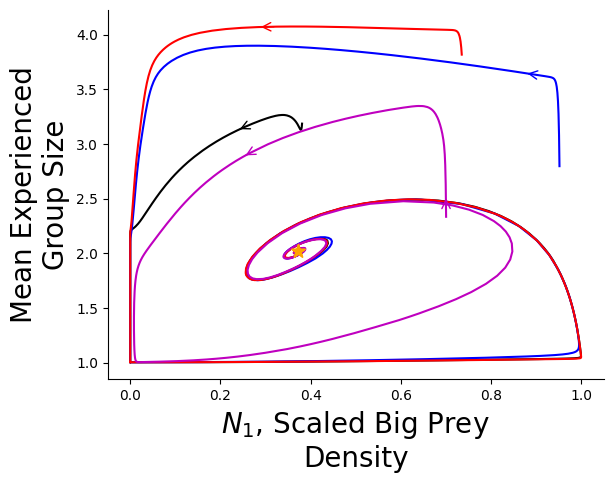

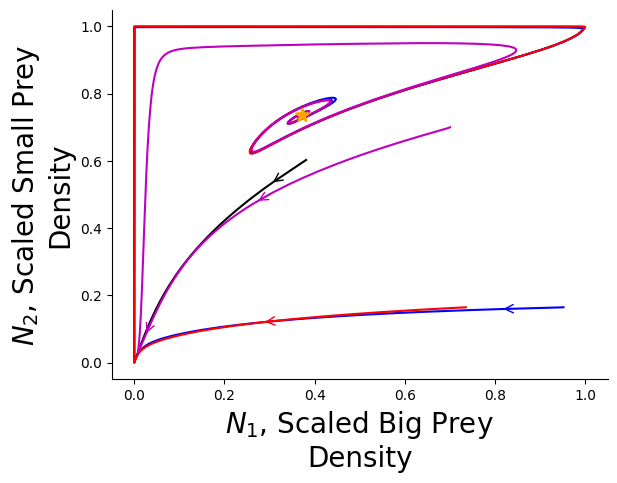

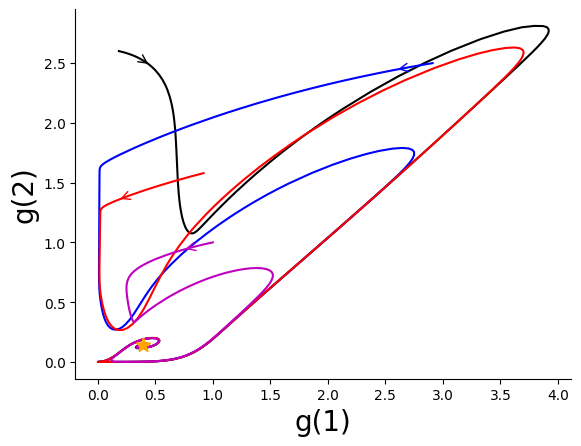

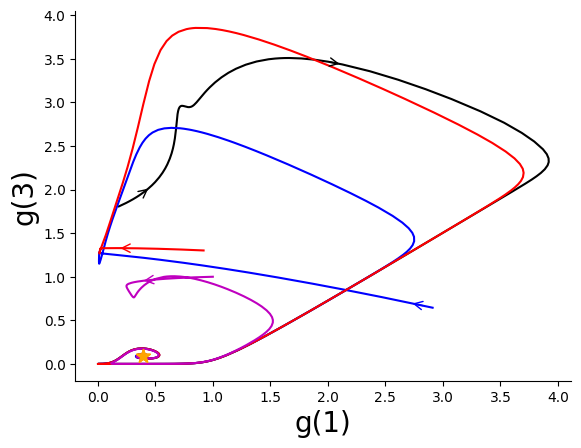

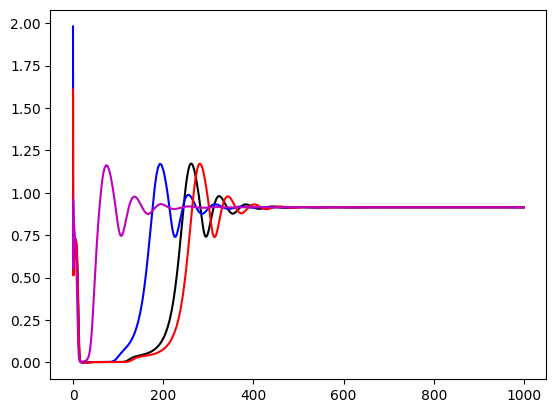

In [26]:

perturbed_pt = [0.7, 0.7, 1,1,1,1e-4,1e-4]
initial_points = get_initial_points(3,**params)
initial_points = np.vstack((initial_points,perturbed_pt))
fig1, figN, fig_g2, fig_g3, _ = make_traj_plots(params, t_f =1000, 
                                        start_inds = start_inds, grp_size2 = 3, 
                                        initial_points=initial_points)

In [60]:
trajectories = get_traj_plot_input(params_base, num_init = 4)

generating initial points


In [51]:
trajs

[{'T': array([0.00000000e+00, 1.12747077e-05, 2.25494154e-05, 4.50988308e-05,
         6.76482462e-05, 9.01976615e-05, 1.40329479e-04, 1.90461296e-04,
         2.40593113e-04, 2.90724930e-04, 3.86308542e-04, 4.81892153e-04,
         5.77475765e-04, 6.73059376e-04, 8.32871793e-04, 9.92684210e-04,
         1.15249663e-03, 1.31230904e-03, 1.57642115e-03, 1.84053325e-03,
         2.10464536e-03, 2.36875746e-03, 2.79801256e-03, 3.22726766e-03,
         3.65652276e-03, 4.08577786e-03, 4.78857266e-03, 5.49136746e-03,
         6.19416226e-03, 6.89695706e-03, 8.08299874e-03, 9.26904042e-03,
         1.04550821e-02, 1.16411238e-02, 1.33920550e-02, 1.51429862e-02,
         1.68939175e-02, 1.86448487e-02, 1.99576739e-02, 2.12704992e-02,
         2.25833244e-02, 2.38863157e-02, 2.51893069e-02, 2.64922981e-02,
         2.77951060e-02, 2.90979138e-02, 3.57761669e-02, 4.24544200e-02,
         4.91326732e-02, 6.07542649e-02, 7.23758566e-02, 8.39974483e-02,
         9.56190401e-02, 1.07240632e-01, 1.188

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='$T$, Scaled time', ylabel='Variance of\nExperienced Group Size'>)

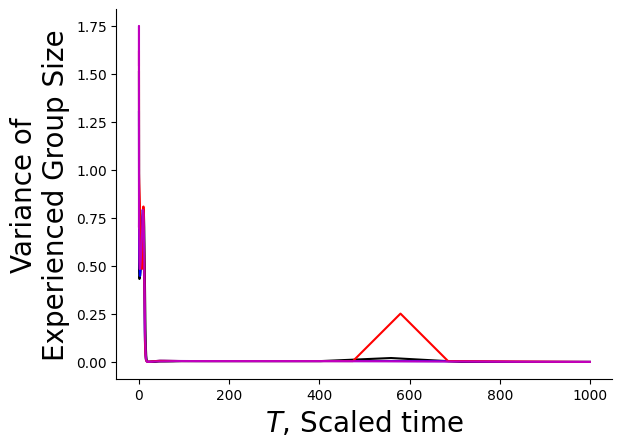

In [61]:
plot_trajectory_vs_T('var', trajectories, 
                     ylab = None, if_legend = False, g_y = None)

In [20]:
plot_trajectory?

Signature:
plot_trajectory(
    key_x,
    key_y,
    trajectories,
    xlab=None,
    ylab=None,
    start_inds=[50, 50, 50, 50],
    if_legend=False,
    g_x=None,
    g_y=None,
)
Docstring:
Plots two state variables from a set of trajectories.

Args:
    key_x (str): The key corresponding to the state variable to plot on the x-axis.
    key_y (str): The key corresponding to the state variable to plot on the y-axis.
    trajectories (list of dict): A list of dictionaries, where each dictionary represents a trajectory.
        Each dictionary should have the state variables as keys, and their values as lists or arrays.
    xlab (str, optional): Label for the x-axis. If not provided, uses `standard_labs[key_x]`.
    ylab (str, optional): Label for the y-axis. If not provided, uses `standard_labs[key_y]`.
    start_inds (list of int, optional): Indices indicating where to start plotting arrows for each trajectory.
        Default is [50, 50, 50, 50].
    if_legend (bool, optional): Whet

# These functions need to be checked for plotting 'F' and W mode 


In [18]:
def plot_F_equilibrium(paramvec, gxvecs, xvec, xlab, ylab, 
                       ncol_legend = 1, xlim = None, ylim = None,
                       fig = None, ax = None):
    '''
    Plots distribution g(x)
    can take for gxvecs either g(x) or \bar{g}(x), 
    the frequency of predators in groups of size x
    NEEDS TO BE UPDATED?
    returns fig, ax
    '''
    if ax == None:
        fig, ax = plt.subplots(1,1)
        
    
    
    colors = ['r', 'orange', 'magenta', 'purple', 'blue', 'cornflowerblue', 'k']

    xmax = len(xvec)
    if gxvecs.shape[1] == xmax:
        gxvecs = gxvecs.T
        
    for x in xvec:
        if np.any(gxvecs[x-1]>1e-2):
            ax.plot(paramvec, gxvecs[x-1], colors[x-1], label = r'$x=$%d'%x)
    format_ax(ax,xlab,ylab, fs_labs = 18, fs_legend = 16, if_legend = True,
             ncol_legend = ncol_legend)
    return fig, ax

'''
def generate_params_using_weitz(A1, β2, H2, η2, weight_fraction_prey, 
                                α1_of_1 = 0.05, α2_of_1 = 0.95, s1 = 2, 
                                s2 = 2, α2_fun_type = 'sigmoid', x_max = 10, 
                                d = 10, Tx = .01):
    attack_fraction = 1/(1/A1 - 1)
    β1 = β2 * attack_fraction * weight_fraction_prey**(0.25)
    H1 = H2 * attack_fraction * weight_fraction_prey**(0.25)
    η1 = η2 * weight_fraction_prey**(-0.25)
    params = dict(η1 = η1, η2 = η2, A1 = A1, β1 = β1, β2 = β2, 
                   H1=H1, H2=H2, 
                  α1_of_1=α1_of_1, α2_of_1=α2_of_1, 
                  s1=s1, s2=s2, α2_fun_type = α2_fun_type,
                  x_max = x_max, d = d,
                 Tx = Tx, r = 0, γ = 0, pop_process = True)
    return params
'''
    
def plot_freq_x_eq(paramvec, gxvecs, xvec, Pvec, xlab, ylab = r'Freq$(x)$', 
                       ncol_legend = 1, xlim = None, ylim = None,
                       fig = None, ax = None):
    '''
    uses plot_F_equilibriumt o plot the frequency of each group size x
    at the (coexistence) equilibrium over time

    OUTDATED?
    returns fig, ax
    '''
    prob_x = (xvec*gxvecs).T/Pvec
    fig, ax = plot_F_equilibrium(paramvec, prob_x, xvec, xlab, ylab, 
                       ncol_legend = ncol_legend, xlim = None, ylim = None,
                       fig = None, ax = None)
    return fig, ax


def plot_W_mode_comparison(xvec,N1vec,N2vec,gxvecs, params, fig = None, ax = None):
    '''
    Plots W(x) for the mode of x, and for x=1, and the mode of x + 1
    '''
    if fig == None:
        fig,ax = plt.subplots(1,1)
    x_mode = np.argmax(xvec*gxvecs,1)+1
    W_of_mode_x_plus_1 = per_capita_fitness_from_prey_non_dim(x_mode + 1, N1vec, N2vec, **params)
    W_of_mode_x = per_capita_fitness_from_prey_non_dim(x_mode, N1vec, N2vec, **params)
    W_of_1 = per_capita_fitness_from_prey_non_dim(1, N1vec, N2vec, **params)
    ax.plot(β1vec, W_of_1, 'crimson', label = r'solitary')
    ax.plot(β1vec, W_of_mode_x, 'magenta', label = r'mode$(x)$')
    ax.plot(β1vec, W_of_mode_x_plus_1 - W_of_1, 'purple', label = r'mode$(x+1)$')

    format_ax(ax, β1lab, 'Per Capita Fitness', if_legend = True)
    return fig, ax

In [85]:
xvec = np.arange(1,x_max+1,1)
β1vec = np.arange(1,10,0.2)
Pvec = np.zeros(len(β1vec))
meanxvec = np.zeros(len(β1vec))
gxvecs  = np.zeros((len(β1vec), x_max))
N1vec = Pvec.copy()
N2vec = Pvec.copy()

for i, β1 in enumerate(β1vec):
    params = params_base.copy()
    params['β1'] = β1
    initialstate = np.array([3, 0.5, 0.5, 3, *np.zeros(9)])
    t_f = 2000
    out2 = solve_ivp(full_model, [0, t_f], initialstate, method="LSODA",
                args=(True,params))
    T,N1,N2,P,gxvec, mean_x = get_results(out2, 10)
    #N1_eq, N2_eq, F_eq, P_eq, mean_x_eq = get_equilibrium(params)
    gxvecs[i,:] = gxvec[:,-1]
    Pvec[i] = P[-1]
    N1vec[i] = N1[-1]
    N2vec[i] = N2[-1]
    meanxvec[i] = mean_x[-1]
    

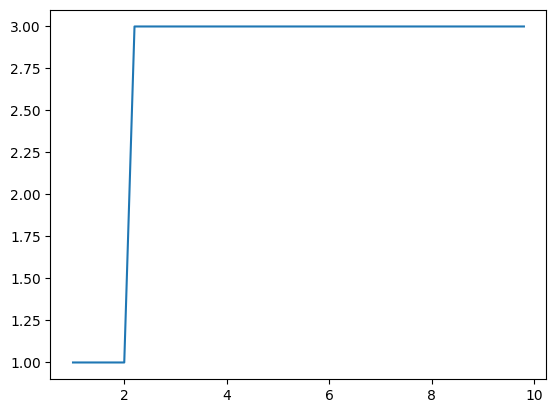

In [103]:
plt.plot(β1vec, x_mode)

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='$\\beta_1$', ylabel='Per Capita Fitness'>)

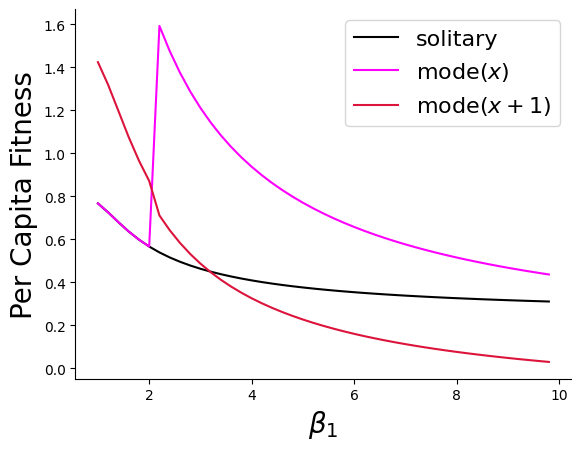

In [132]:
plot_W_mode_comparison(xvec,gxvecs)

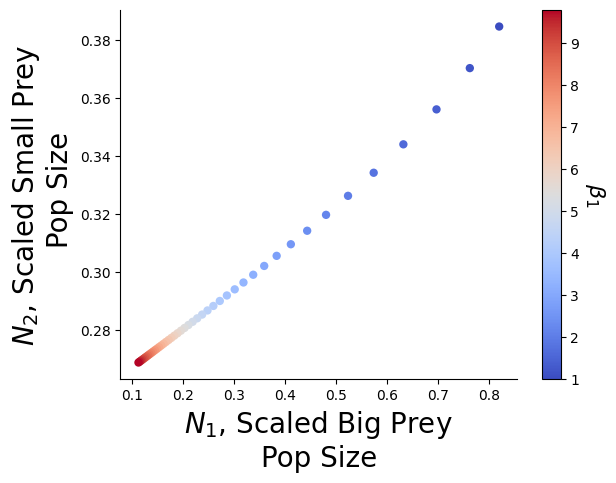

In [79]:
from matplotlib import cm

fig, ax = plt.subplots(1,1)
p = plt.scatter(N1vec,N2vec, c = β1vec, cmap = 'coolwarm', edgecolor='none')
cb = plt.colorbar(p, label = β1lab)
cb.set_label(label=β1lab, rotation = 270, fontsize = 16, labelpad = 20)
#plt.plot(N1vec,N2vec, 'k')
format_ax(ax,N1lab,N2lab)

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='$\\beta_1$', ylabel='Freq$(x)$'>)

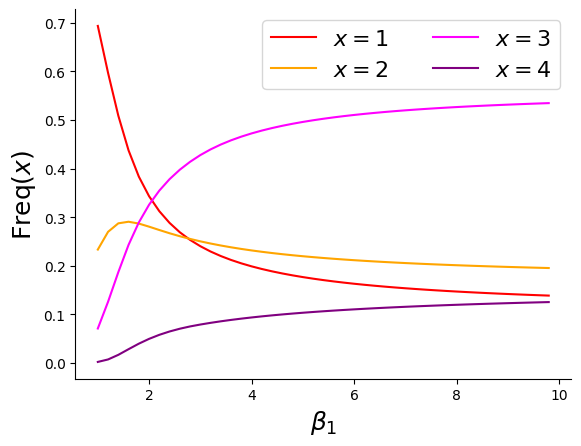

In [49]:
freq_x_lab = r'Freq$(x)$'
plot_freq_x_eq(β1vec, gxvecs, xvec, P, β1lab, 
                       ncol_legend = 2,
                       )

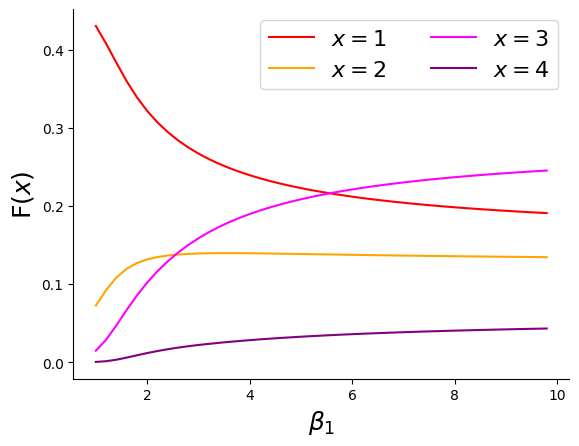

In [50]:
fig,ax = plot_F_equilibrium(β1vec, gxvecs, xvec, β1lab, gxlab, ncol_legend=2)

10

In [83]:
gxvecs.shape[1]

10

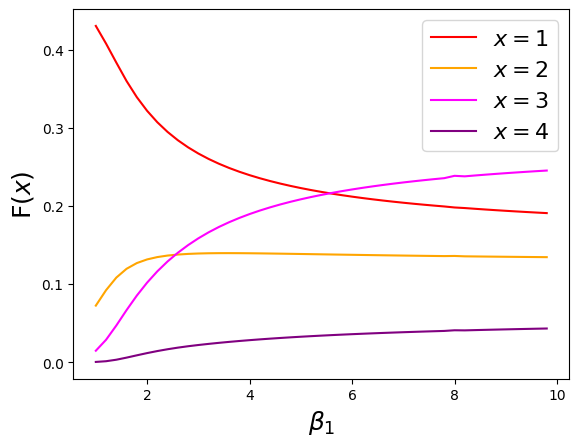

In [80]:

colors_x = ['r', 'orange', 'magenta', 'purple', 'blue', 'cornflowerblue', 'k']
for x in xvec:
    if np.any(prob_x[x-1]>1e-2):
        plt.plot(β1vec, (gxvecs.T)[x-1], colors_x[x-1], label = r'$x=$%d'%x)
    




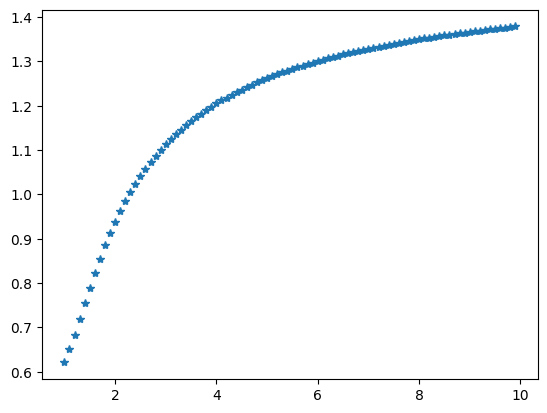

In [14]:
plt.plot(β1vec, Pvec, '*')

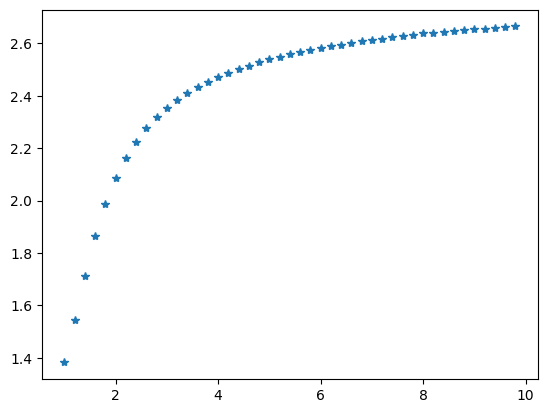

In [16]:
plt.plot(β1vec, meanxvec, '*')

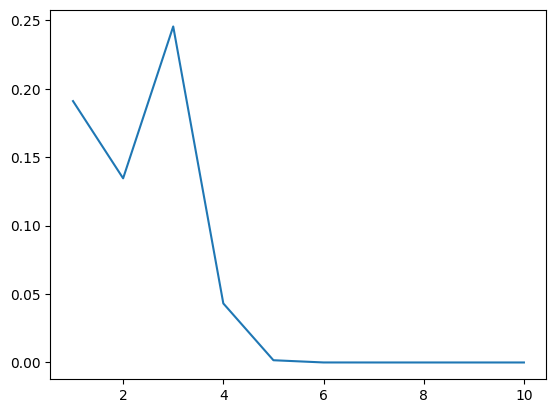

In [26]:
xvec = np.arange(1,11,1)
plt.plot(xvec,gxvec[:,-1])

# Weitz Scaling parameters

In [20]:
#H=1
A1 = 0.5
attack_fraction = 1/(1/A1 - 1)
weight_fraction_prey = 10 # m1/m2

β2 = 1; H2 = 2; η2 = 0.5
β1 = β2 * attack_fraction * weight_fraction_prey**(0.25)
H1 = H2 * attack_fraction * weight_fraction_prey**(0.25)
η1 = η2 * weight_fraction_prey**(-0.25)



x_max = 10
params_base = dict(η1 = η1, η2 = η2, A1 = A1, β1 = β1, β2 = β2, 
                   H1=H1, H2=H2, 
                  α1_of_1=0.05, α2_of_1=0.95, 
                  s1=2, s2=2, α2_fun_type = 'sigmoid',
                  x_max = x_max, d = 10,
                 Tx = .01, r = 0, γ = 0, pop_process = True)


In [21]:
params = params_base.copy()

In [22]:
x_max = params['x_max']
x_f = 4 if x_max > 4 else x_max
F0 = np.zeros(x_max)
F0[0:x_f]

array([0., 0., 0., 0.])

In [28]:
iterate_and_solve_equilibrium?

Signature: iterate_and_solve_equilibrium(params, t_f=1000)
Docstring:
iterates from p = 3, N1 = 0.8, N2 = 0.7, 
predators split evenly between groups of 1, 2, or 3
then uses root to find equilibrium

@returns
P,N1,N2,F,mean_x at equilibrium, 
and success (Boolean; true if the equilibria values are all nonnegative)
File:      /var/folders/_4/t51wvvv53c35d1q0pv8mywxr0000gq/T/ipykernel_86949/1254172374.py
Type:      function

In [35]:
P,N1,N2,g,mean_x,success = iterate_and_solve_equilibrium(params.copy(), t_f = 2)
print(g)

[1.24675552e+00 4.32098312e-02 1.75351442e-04 1.90101797e-07
 1.47655237e-10 9.44009770e-14 5.16321243e-17 2.47002668e-20
 1.05024029e-23 4.01888891e-27]


In [143]:
P0 = 3
xvec = np.arange(1,11,1)
F0 = np.zeros(x_max) 
F0[0:2] = P0/2
F0 = F0/xvec
x0 = [0.8, 0.7, *F0]
params = params_base.copy()

out = root(fun = nullclines_no_P, x0 = x0, args = (params))

In [146]:
out.success

True

In [145]:
out.x

array([9.18249546e-01, 3.44957930e-01, 1.23103242e+00, 7.15181976e-02,
       5.20552700e-04, 1.10501744e-06, 1.70616996e-09, 2.17213180e-12,
       2.36635778e-15, 2.25494432e-18, 1.90986340e-21, 1.45579673e-24])

In [137]:
f_all_solitary = np.zeros(10); f_all_solitary[0] = P0
params = params_base.copy()
out2 = solve_ivp(full_model, [0, 2000], [P0,0.5, 0.4, *f_all_solitary], method="LSODA",
                args=(True,params))

In [138]:
T,N1,N2,P,gxvec, mean_x = get_results(out2, 10)


In [139]:
out_end = np.round([N1[-1], N2[-1], *gxvec[:,-1]],5)
out = root(fun = nullclines_no_P, x0 = out_end, args = (params))

In [140]:
out.x

array([9.18249546e-01, 3.44957930e-01, 1.23103242e+00, 7.15181976e-02,
       5.20552700e-04, 1.10501744e-06, 1.70616996e-09, 2.17213180e-12,
       2.36635778e-15, 2.25494432e-18, 1.90986340e-21, 1.45579673e-24])

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='$N_1$, Scaled Big Prey\nPop Size', ylabel='$P$, Scaled Pred. Pop Size'>)

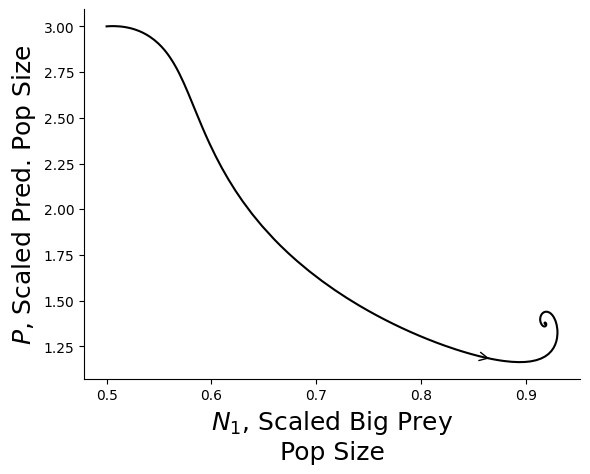

In [106]:
plot_x_vs_y(N1,P,N1lab,Plab,[100])

In [153]:
g_of_x_vec

array([0.3       , 0.15      , 0.1       , 0.075     , 0.06      ,
       0.05      , 0.04285714, 0.0375    , 0.03333333, 0.03      ])

In [144]:
out = get_equilibrium(params_base.copy())

 message: The iteration is not making good progress, as measured by the 
            improvement from the last ten iterations.
 success: False
  status: 5
     fun: [ 4.129e-03  2.313e-03  5.658e-03 -7.858e-03 -6.351e-03
            4.506e-03 -1.249e-02  1.713e-03 -1.457e-02  4.653e-03
            1.407e-02 -1.331e-02]
       x: [-3.092e-01  1.263e-01  5.993e-02  3.248e-01 -9.217e-02
            2.821e-01 -2.059e-01  3.011e-01 -1.676e-01  1.936e-01
           -6.279e-02  9.788e-02]
  method: hybr
    nfev: 102
    fjac: [[ 7.026e-04 -4.825e-12 ...  2.195e-01 -1.368e-01]
           [-5.342e-02 -1.390e-02 ...  9.005e-02 -5.816e-02]
           ...
           [ 3.748e-02 -2.489e-03 ... -1.494e-01  8.294e-01]
           [ 4.389e-01 -1.761e-03 ... -4.099e-01 -4.433e-01]]
       r: [-2.847e+02  2.187e+03 ... -2.085e+00 -1.059e+00]
     qtf: [-5.391e-03 -1.143e-02  1.325e-03  1.227e-03  7.104e-03
           -4.459e-03  5.270e-03 -1.073e-02  1.669e-02  1.236e-02
           -8.609e-03  7.937e-03

In [84]:
initialstate = np.array([3,0.4, 0.5, 3, *np.zeros(9)])
t_f = 1000
params = params_base.copy()
out2 = solve_ivp(full_model, [0, t_f], initialstate, method="LSODA",
                args=(True,params))
T,N1,N2,P,gxvec, mean_x = get_results(out2, 10)

In [33]:
bounds = [(0,1),(0,1)]
for x in range(1, params['x_max']+1):
    bounds.append((0,None))
    
initialstate = initialstate + 0.01
def abs_nullclines_no_P(initialstate, params):
    return np.sum(np.abs(nullclines_no_P(initialstate, params)))
    
x_max = params['x_max']
#N1, N2 = initialstate[0:2]
#g_of_x_vec = initialstate[2:]

out = minimize(fun = abs_nullclines_no_P, x0 = initialstate[1:], args = (params), 
               bounds = bounds)

In [34]:
out

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.1999999999999996
        x: [ 2.058e-15  1.000e+00  0.000e+00  0.000e+00  0.000e+00
             0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
             0.000e+00  0.000e+00]
      nit: 13
      jac: [-2.000e-01 -4.000e-01  2.750e+00  3.037e+02  4.543e+02
             6.051e+02  7.559e+02  9.067e+02  1.057e+03  1.208e+03
             1.359e+03  1.510e+03]
     nfev: 1183
     njev: 91
 hess_inv: <12x12 LbfgsInvHessProduct with dtype=float64>

In [ ]:
x_max = params['x_max']
if ~isinstance(g_of_x_vec, np.ndarray):
    g_of_x_vec = np.zeros(x_max)
    g_of_x_vec[0] = P_0
x0 = [N1_0, N2_0, *g_of_x_vec]
out, infodict, ier, mesg = fsolve(func = nullclines_no_P, x0 = x0, 
                              args = (params), full_output = 1)
F_eq = out[2:]
P_eq = np.sum(np.arange(1,x_max+1,1)*F_eq); 
N1_eq = out[0]
N2_eq = out[1]
mean_x_eq = mean_group_size_membership(F_eq,x_max,P_eq)

if np.any( np.round(np.array([N1_eq, N2_eq, *F_eq, P_eq, mean_x_eq]),8) <0):
    return np.nan, np.nan, np.nan, np.nan, np.nan
else:
    return N1_eq, N2_eq, F_eq, P_eq, mean_x_eq